In [1]:
import pandas as pd 
import numpy as np

Let's do some basic data cleaning! First let's drop some duplicate tracks.

In [20]:
spotify_df = pd.read_csv('SpotifyFeatures.csv')
spotify_df[spotify_df['track_id'] == "6iOvnACn4ChlAw4lWUU4dd"]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
257,R&B,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
1348,Alternative,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
77710,Children’s Music,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
93651,Indie,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
113770,Pop,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7


For this id, we can see that if a song appears across generes, it will be a duplicate entry. For simplicity, I'm going to remove duplicate IDs and keep the first ID.

In [21]:
spotify_df = spotify_df.drop_duplicates(subset=["track_id"], keep="first")
spotify_df[spotify_df['track_id'] == "6iOvnACn4ChlAw4lWUU4dd"]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
257,R&B,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7


<Axes: xlabel='popularity', ylabel='Count'>

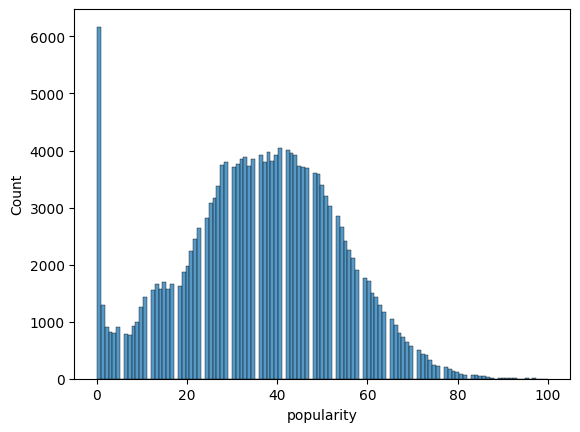

In [4]:
import seaborn as sns

sns.histplot(spotify_df, x="popularity")

In this histogram, we can see that the dataset contains a lot of (no judgement!) low-popularity songs. Let's add a baseline popularity to analyze more relevant songs.

<Axes: xlabel='popularity', ylabel='Count'>

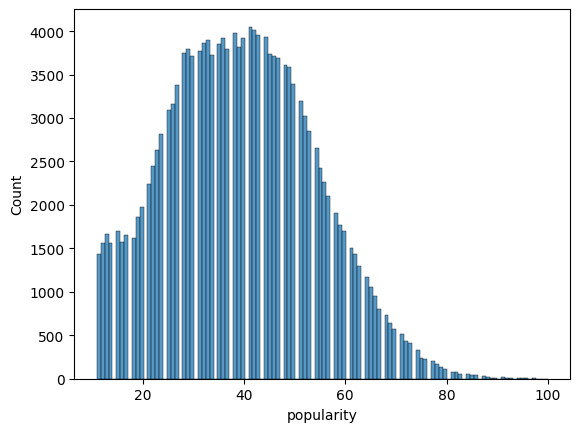

In [5]:
sns.histplot(spotify_df[spotify_df['popularity'] > 10], x="popularity")

In [22]:
spotify_df = spotify_df[spotify_df["popularity"] > 10]

I want to store track metadata for retrieval in the future, and eventually the results of our cluster analysis. Let's store the data in our DuckDB instance and stand up some initial tables.

In [23]:
from setup_db import DB_NAME
import duckdb

with duckdb.connect(database=DB_NAME) as con:
    con.execute("CREATE TABLE track AS SELECT * FROM spotify_df")
    con.execute("ALTER TABLE track ADD PRIMARY KEY (track_id)")
    con.execute("CREATE TABLE cluster (id INTEGER PRIMARY KEY, x FLOAT, y FLOAT, size FLOAT)")
    con.execute(
        """
        CREATE TABLE track_to_cluster 
        (track_id VARCHAR, cluster_id INTEGER, 
        FOREIGN KEY (track_id) REFERENCES track (track_id),
        FOREIGN KEY (cluster_id) REFERENCES cluster (id))
        """
        )


Great! Now we can start some analysis to store in our db. We have a few categorical variables, like genre and key with many options, and mode that we could consider to be a boolean. Because of this mix of data types, I will first calculate a gower distance matrix to find similary between tracks. We'll at this point also define our train & test split.

In [32]:
import gower

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# use our track id as index for convenience & drop metadata
spotify_df = shuffle(spotify_df)
df = spotify_df.set_index('track_id').drop(columns=['artist_name','track_name']).head(10000)

dist_matrix = gower.gower_matrix(df)

indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices,train_size=0.8,random_state=42)
dist_matrix_train = dist_matrix[np.ix_(train_idx, train_idx)]
dist_matrix_test = dist_matrix[np.ix_(test_idx, test_idx)]


With our distance matrix computed, we can do a basic parameter sweep with sklearn's Agglomerative Clustering function. I chose this as it accepts non-euclidean distances as a metric.

In [33]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

cluster_scores = {}
for n in range(2, 15):
    cluster = AgglomerativeClustering(metric="precomputed", n_clusters=n, linkage="average")
    cluster.fit(dist_matrix_train)
    pred_labels = cluster.fit_predict(dist_matrix_test)

    score = silhouette_score(dist_matrix_test, pred_labels, metric="precomputed")
    cluster_scores[n] = score

best_cluster = max(cluster_scores, key=cluster_scores.get)



{2: 0.26268523931503296,
 3: 0.2642061114311218,
 4: 0.22280752658843994,
 5: 0.16918402910232544,
 6: 0.14912346005439758,
 7: 0.12235525250434875,
 8: 0.11444175988435745,
 9: 0.10495351254940033,
 10: 0.09827244281768799,
 11: 0.14997531473636627,
 12: 0.14622534811496735,
 13: 0.1435374915599823,
 14: 0.1473928838968277}

In [35]:
cluster = AgglomerativeClustering(n_clusters=best_cluster, metric="precomputed", linkage="average")
cluster.fit(dist_matrix_train)
cluster.fit_predict(dist_matrix)

df["cluster_label"] = cluster.labels_

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,cluster_label
track_id,,,,,,,,,,,,,,,,
4iTfml41SOUBHXgMUHLUVV,Jazz,38,0.96900,0.224,131200,0.179,0.00193,G#,0.1060,-16.515,Major,0.0323,86.344,3/4,0.1680,0
5eKGXOWXDwH4Mtftq26r55,Country,42,0.12000,0.731,196147,0.693,0.00000,E,0.1770,-6.522,Major,0.0253,109.999,4/4,0.9250,0
6XsQPwtX01TNUPD5WGhfXs,Reggae,31,0.25300,0.662,237333,0.675,0.00000,A,0.0430,-6.516,Major,0.1530,179.154,4/4,0.8070,0
7rtOWu3ZEDb7cmV0O2JbgQ,Soul,43,0.31200,0.708,191476,0.769,0.00000,B,0.2520,-6.241,Minor,0.2950,110.736,5/4,0.8680,0
2u6tZMWwhgnRggKHvRWINP,Electronic,45,0.00577,0.381,267800,0.937,0.01550,G,0.1690,-4.782,Major,0.0391,173.958,4/4,0.0397,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5kKNwf91GRfbQlIYv81Frz,Blues,40,0.03170,0.597,250053,0.747,0.03280,C,0.1140,-3.988,Major,0.0553,135.931,4/4,0.4490,0
4StBMIFXJl9ObFMdeEQD6S,Children’s Music,44,0.01870,0.305,200773,0.763,0.00143,F#,0.2260,-7.551,Major,0.0528,146.685,3/4,0.5500,0
1dekgAFF9uTCqLsklDaCWb,Rock,68,0.00183,0.483,221560,0.907,0.05090,G#,0.1520,-7.015,Major,0.0413,96.014,4/4,0.2960,0


<Axes: >

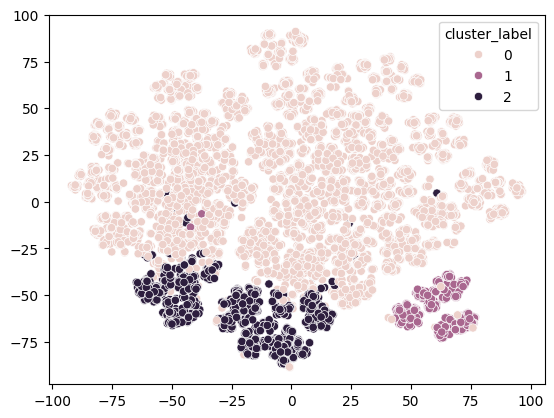

In [43]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
xy = t_sne.fit_transform(dist_matrix)
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=df['cluster_label'])

Our gower distance calc resulted in some overlapping clusters - let's try a different method to find similar song clusters! This time I'll use k-means clustering and encode the categorical variables.

<Axes: >

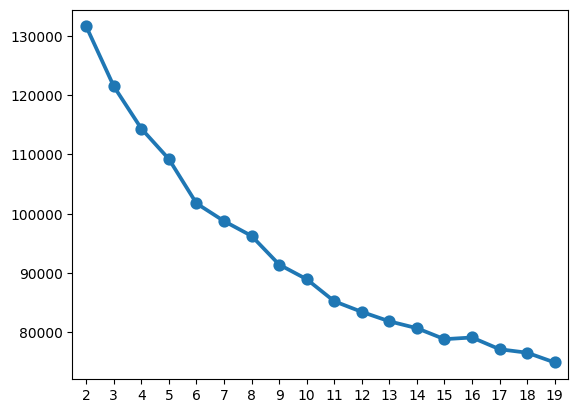

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df: pd.DataFrame = spotify_df.set_index('track_id').drop(columns=['artist_name','track_name']).head(10000)
categorical_df = df.select_dtypes(exclude=['number']).columns
def encode(column: pd.Series):
    unique_vals = column.unique()
    encoding_map = {col: i for i,col in enumerate(unique_vals)}
    column = column.map(encoding_map)
    return column

df = df.apply(lambda x: encode(x) if x.name in categorical_df else x)
scaler = StandardScaler()
df_znorm = scaler.fit_transform(df)
best_cluster = {}

for n in range(2,20):
    kmeans = KMeans(n_clusters=n, random_state=42)
    cluster = kmeans.fit(df_znorm)
    best_cluster[n] = cluster.inertia_

sns.pointplot(x=best_cluster.keys(), y=best_cluster.values())


In [12]:
best_cluster_n = 12
kmeans = KMeans(n_clusters=best_cluster_n, random_state=42)
kmeans.fit_predict(df_znorm)
centroids = kmeans.cluster_centers_
df["cluster_labels"] = kmeans.labels_



<Axes: >

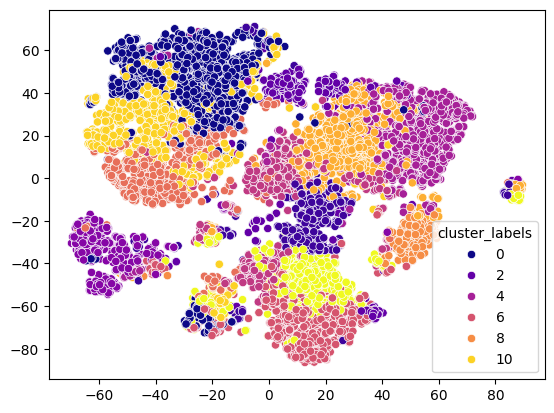

In [13]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2, random_state=42)
xy_centroids = t_sne.fit_transform(np.vstack([df_znorm, centroids]))

xy = xy_centroids[:-len(centroids)]
centroid_coords = xy_centroids[-len(centroids):]

sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=df['cluster_labels'], palette='plasma')

In [31]:
from cluster_grid import generate_cluster_positions_df

cluster_info = generate_cluster_positions_df(df['cluster_labels'], n_clusters=best_cluster_n, layout_type='circular')
cluster_info = cluster_info.rename(columns={'cluster_id':'id', 'x_position':'x', 'y_position':'y','cluster_size':'size'})
with duckdb.connect(database=DB_NAME) as con:
    con.execute("INSERT INTO cluster BY NAME SELECT * FROM cluster_info")

cluster_info

,id,x,y,size
0,0,3.0,0.000000e+00,1572
1,1,1.5,2.598076e+00,536
2,2,-1.5,2.598076e+00,390
3,3,-3.0,3.673940e-16,558
4,4,-1.5,-2.598076e+00,1178
5,5,1.5,-2.598076e+00,747
6,6,6.0,0.000000e+00,934
7,7,3.0,5.196152e+00,846
8,8,-3.0,5.196152e+00,323
9,9,-6.0,7.347881e-16,1162


In [42]:
trackdf = df[['cluster_labels']].reset_index().rename(columns={'cluster_labels':'cluster_id'})
with duckdb.connect(database=DB_NAME) as con:
    con.execute("INSERT INTO track_to_cluster BY NAME SELECT * FROM trackdf")

trackdf


,track_id,cluster_id
0,0PbIF9YVD505GutwotpB5C,5
1,3JO7xCEBoFzVpuO42LTTB4,11
2,2YegxR5As7BeQuVp2U6pek,11
3,6KFaHC9G178beAp7P0Vi5S,11
4,6muW8cSjJ3rusKJ0vH5olw,11
...,...,...
9995,7GGRskGpD6AqkpZshKSyBT,6
9996,2VVSfYOHNu4pCahfxvgyJR,5
9997,0LBmvPJYmtEJ7kkWvc3kbT,3
9998,25FeM2rqMbcySLJ4dxS2iU,1


In [ ]:
from annoy import AnnoyIndex

index = AnnoyIndex(n_features, 'euclidean')
for song_id, features in your_song_data:
    index.add_item(song_id, features)
index.build(n_trees=10)  # more trees = better accuracy, slower build
index.save('songs.ann')

# Query phase (in your app)
index.load('songs.ann')
similar_ids = index.get_nns_by_vector(query_features, n=10)